# Visualising and analysing 7m telescope data

You can use this notebook to visualise the data you recorded from the telescope and learn about how you can extract relevant information from them.

## Using the notebook

You can write python code in the cells. Execute the code with Ctrl-Enter. The results are displayed below the cell.
 
Cells can also contain annotations like this one. A cell can be toggled between code and "[markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)" in the drop-down menu above. The annotation cells can be written in plain text, but also support markdown formatting, a cheat-sheet for which can be found at the above link. Double-click to edit the text, and Ctrl-Enter return to the formated version. Try it on this comment.

## Load the required libraries

We mainly make use of two libraries in this template: Numpy and matplotlib. You may be familiar with these from other courses.
 
Numpy provides routines for doing lots of math stuff. Here we import the numpy library with a short name `np` 

We will import the matplotlib package as `plt` in order to use it to make all kinds of plots.
 
Numpy (and the related scipy) have very powerful tools for doing all kinds of operations, including fitting functions to data. You can find lots of information on these methods if you search around the web and in the numpy manual, and do talk to your demonstrator.
 
We don't need all these just for plotting, but some e.g. astropy might be very useful for other tasks.
 

In [14]:
# To begin, we import some libraries that we will need later.

import numpy as np    # The numpy module for various numerical operations
from  matplotlib import pyplot as plt   # The pyplot module from matplotlib will allow us to plot things.
from os import walk        # Allows us to list files in a directory
#import importlib         # Allows to import a seperate python file as a module
import sys               # Some other system level functions


In [15]:
# Connect (mount) your google drive as a virtual directory accessible by this python code.
#from google.colab import drive         # Import the python module that allows you to access your google drive
#rootpathdrive = '/content/drive'       # This will be the directory as which your google drive will be known
#drive.mount(rootpathdrive)             # Now connect to this google drive. 

# At first use it will ask you to click on a link, after which you should give permission 
# for outside processes to access your google drive. A authorization code is generated which should be entered 
#(this is explained in https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd).

In [16]:
# A good test to do is if you can see the contents of the directory in which you work on your google drive.
# Here "My Drive" refers to the "root" of your google drive.
# By default your notebook should be in a directory called Colab Notebooks.
# This template assumes all files you want to read in are copied in the
# same directory. Note the slash at the end of the first line.
path7m = '/home/fvp/Downloads/7m/'
filelist = []
for (dirpath, dirnames, filenames) in walk(path7m):
    filelist.extend(filenames)
    break
print (filelist)   # Show the contents of your working directory. At least example.ipynb and lib7m.py should show up here.

['exampleS7.csv', 'exampleCASA.csv', 'example.ipynb', 'calc.py', '7m_template.zip', 'lib7m.py']


In [17]:
# This following module defines some functionality related to the handling of 7m telescope data. 
# Their functions will be demonstrated below. You may modify/extend these functions as you see fit.

#sys.path.insert(1, path7m)    # Let python know that modules could live on your google drive folder
#os.chdir(path7m)
import lib7m


# Load and plot a scan

Opening file /home/fvp/Downloads/7m/exampleCASA.csv
  Done with reading in 239 scan points


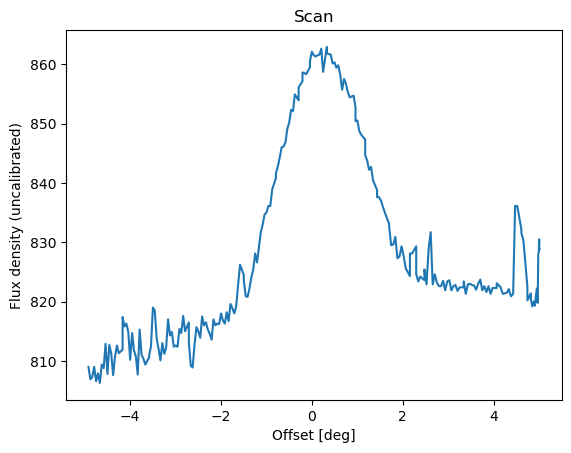

In [18]:
# Load an example of a scan (CAS A). The data is returned as a list of two numpy arrays, corresponding to the offset (in degrees), and flux density (calibrated). So for example spectrum[0][9] is the offset of the 10th point in the scan (python defined the first element of an array with index 0). And spectrum[1][0] is the flux density of the first point in the scan. 
scan = lib7m.load_scan(path7m+"exampleCASA.csv")


# The following makes a plot of the scan that was just loaded. Here we choose offset (stored in scan[0]) as the x-axis and flux density (stored in scan[1]) as the y-axis.
plt.figure()
plt.plot(scan[0], scan[1])
plt.xlabel("Offset [deg]")
plt.ylabel("Flux density (uncalibrated)")
plt.title("Scan")
plt.show()

Making a plot of your scans is enough to complete what you need to do with your scans in the experiment. It can perfectly well be analysed with a ruler & pencil approach. Reading further might give you some ideas of how to manipulate the data in your scan with python. What follows is related to dealing with spectra.

# Spectral analysis

The following loads a spectra. Then this raw data as recorded needs to be flux calibrated (a scaling of the temperatures to ensure they are in Kelvin), as well as corrected for a velocity dependent "baseline" (a subtraction).

Opening file /home/fvp/Downloads/7m/exampleS7.csv
  Done with reading in 1024 spectral points


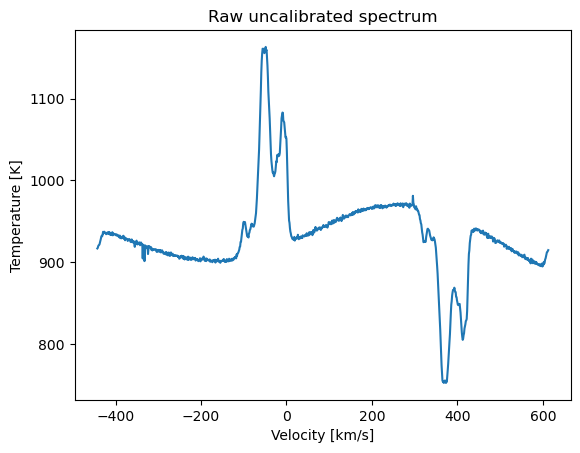

In [19]:
# Load an example spectrum of S7. The data is returned as a list of three numpy arrays, 
# corresponding to the frequency (in MHz), velocity (in km/s) and the temperature (in K). 
# So for example spectrum[1][9] is the velocity of the 10th spectral bin (python defined 
# the first element of an array with index 0). And spectrum[2][0] is the temperature of 
# the first spectral bin. 
spectrum = lib7m.load_spectrum(path7m+"exampleS7.csv")

# The following makes a plot of the raw spectrum that was just loaded. Here we choose 
# velocity (stored in spectrum[1]) as the x-axis and temperature (stored in spectrum[2]) as the y-axis.
plt.figure()
plt.plot(spectrum[1], spectrum[2])
plt.xlabel("Velocity [km/s]")
plt.ylabel("Temperature [K]")
plt.title("Raw uncalibrated spectrum")
plt.show()

Cutting 155 of the 1024 spectral channels
Cutting 313 of the 869 spectral channels


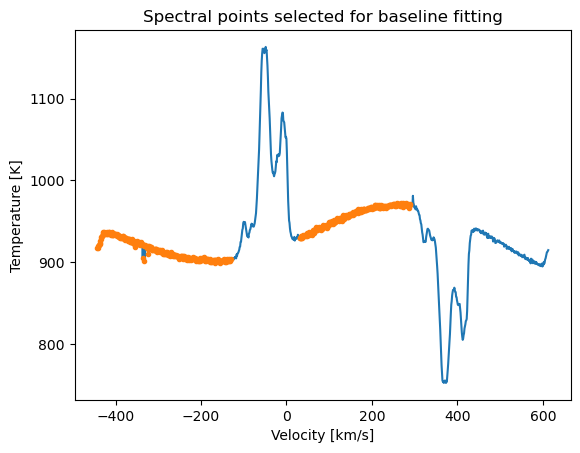

In [20]:
# You can see the spectral line is superimposed on top of a baseline. To remove it, 
# a polynomial can be fitted to the baseline. This fit (based on values outside the 
# spectral line) can be used to predict the expected shape of the baseline within 
# the spectral line. To do the fitting, we should get rid of the spectral line first. 
# In the lib7m module a python function is defined which allows you to remove a velocity 
# range from the spectrum. Here we call the function twice to remove two velocity ranges. 
# The plot shows what the remaining values are in the spectrum, which will be used in the fit.
spectrum_cut1 = lib7m.cut_velocity_range(spectrum, -130.0, 30.0)         # Removes the HI line
spectrum_cut2 = lib7m.cut_velocity_range(spectrum_cut1, 290.0, 700.0)    # Removes last part of the spectrum

plt.figure()
plt.plot(spectrum[1], spectrum[2], spectrum_cut2[1], spectrum_cut2[2], '.')
plt.xlabel("Velocity [km/s]")
plt.ylabel("Temperature [K]")
plt.title("Spectral points selected for baseline fitting")
plt.show()

Found fit coefficients:  [-3.04772569e-09 -1.55969304e-06  4.78777328e-04  2.23430283e-01
  9.21147878e+02]


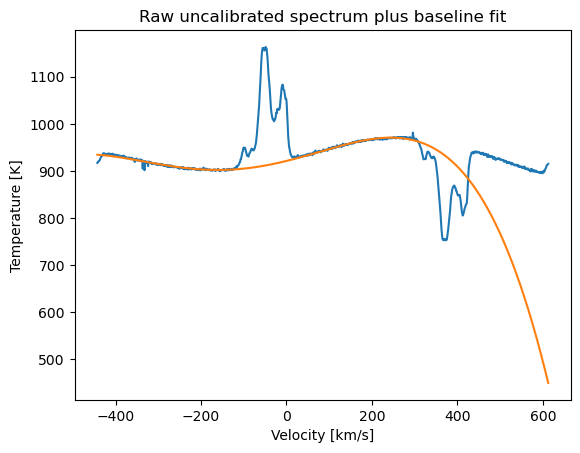

In [21]:
# Fit a polynomial to the selected data to estimate the shape of the baseline 
# underneath the spectral line, and show the result. A fourth order polynomial 
# was choosen in this example.
coeff = np.polyfit(spectrum_cut2[1], spectrum_cut2[2], 4)

# Show the found coefficients of the polynomial defining temperature as 
# function of velocity (a numpy array)
print ("Found fit coefficients: ",coeff)   

# Define a function which returns temperature for a given velocity. 
# So fitfunction(0) would return the resulting temperature at zero velocity.
fitfunction = np.poly1d(coeff)   

plt.figure()
plt.plot(spectrum[1], spectrum[2], spectrum[1], fitfunction(spectrum[1]))
plt.xlabel("Velocity [km/s]")
plt.ylabel("Temperature [K]")
plt.title("Raw uncalibrated spectrum plus baseline fit")
plt.show()

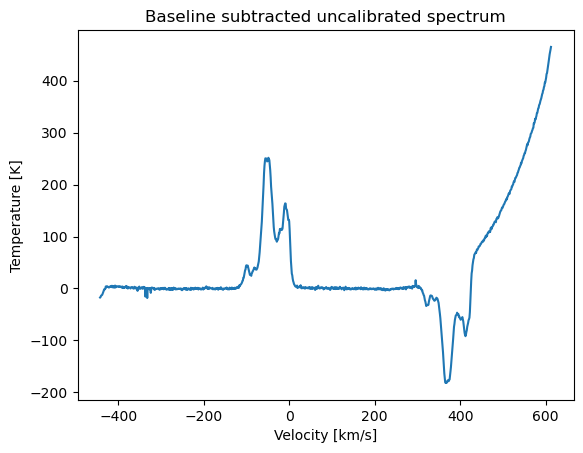

In [22]:
# Now subtract the baseline fit function and show the result.
spectrum[2] -= fitfunction(spectrum[1])

plt.figure()
plt.plot(spectrum[1], spectrum[2])
plt.xlabel("Velocity [km/s]")
plt.ylabel("Temperature [K]")
plt.title("Baseline subtracted uncalibrated spectrum")
plt.show()

In [23]:
# Measure the rms from the baseline data. This rms is required
# to calculate an error on the temperature integral.

# The selected points outside the HI line we used to fit the shape
# of the baseline provides a clean part of the spectrum to estimate
# the rms. To estimate the rms we can remove the average first
# (smooth shape of the baseline)
spectrum_cut2[2] -= fitfunction(spectrum_cut2[1])

# and then take the sqrt of the mean of the squares of the values.
rms = np.sqrt(np.mean((spectrum_cut2[2])**2))
print ("measured RMS = %f K" %(rms))

measured RMS = 2.625539 K


In [24]:
# Now compute the temperature integral over the specified velocity range (HI line).
# The full (uncut in terms of velocity range) spectrum is expected as an input, as 
# otherwise the velocity resolution might be misinterpretted, leading to a
# wrong normalisation. Before the temperature integral the baseline must be removed first.
tempint = lib7m.velocity_integral(spectrum, -130.0, 30.0, rms)

Temperature integral is (12910.855413 +- 33.719969) K km/s


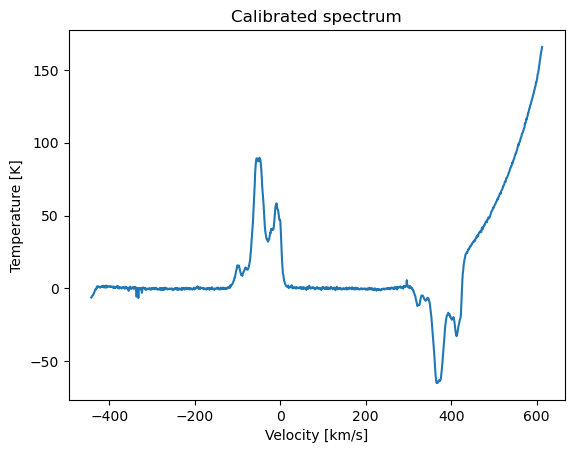

In [25]:
# Scale the spectrum such that the temperature integral is 4600 K km/s, which is 
# what the temperature integral should be.
spectrum[2] *= 4600.0/tempint

plt.figure()
plt.plot(spectrum[1], spectrum[2])
plt.xlabel("Velocity [km/s]")
plt.ylabel("Temperature [K]")
plt.title("Calibrated spectrum")
plt.show()

# Be carefull with executing cells multiple times, as you want apply for example 
# the normalisation factor once.

In [26]:
# The following assumes you have two spectra loaded in, called spectrum1 and spectrum2.
# If you have multiple observations of the same source (identical integration times)
# one might want to average the spectra to get a higher signal-to-noise spectrum.
# The average spectrum can easily be obtained as follows:

# Make a copy of the first spectrum (velocities, frequencies and temperatures)
spectrum_avrg = spectrum1
# Replace the temperatures in the copy with the average temperature of the two spectra
spectrum_avrg[2] = 0.5*spectrum1[2] + 0.5*spectrum2[2]

NameError: name 'spectrum1' is not defined